# Titanic machining learning

## 0. Import library and data

In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [150]:
df_train=pd.read_csv("train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [151]:
df_test=pd.read_csv("test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1. Data exploration

### 1.1. Missing values

In [152]:
mis_feat=df_train.isnull().sum()
print(mis_feat[mis_feat>0])
mis_feat=df_test.isnull().sum()
mis_feat[mis_feat>0]

Age         177
Cabin       687
Embarked      2
dtype: int64


Age       86
Fare       1
Cabin    327
dtype: int64

### 1.2. Relationship between independent variables(X) and dependent variable(Y)

#### 1.2.1. Numerial variables

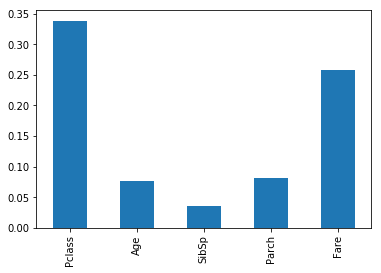

In [153]:
df_train[["Pclass","Age","SibSp","Parch","Fare"]].corrwith(df_train.Survived).apply(np.abs).plot.bar()
plt.show()

#### 1.2.2. Non-numerial variables

female    0.543351
male     -0.543351
dtype: float64

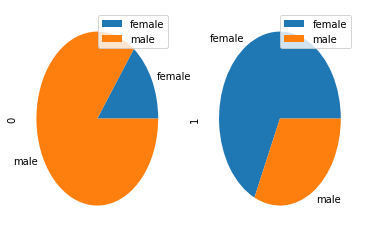

In [154]:
# Sex
pd.crosstab(df_train.Sex,df_train.Survived).plot(kind="pie",subplots=True)
pd.get_dummies(df_train.Sex).corrwith(df_train.Survived)

C    0.16824
Q    0.00365
S   -0.15566
dtype: float64

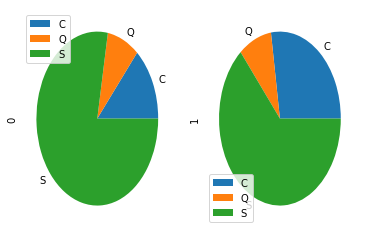

In [155]:
# Sex
pd.crosstab(df_train.Embarked,df_train.Survived).plot(kind="pie",subplots=True)
pd.get_dummies(df_train.Embarked).corrwith(df_train.Survived)

## 2. Feature engineering

### 2.1. Fill missing values

In [156]:
ndf_train=df_train[["Survived","Pclass","Fare"]].copy()
ndf_test=df_test[["Pclass","Fare"]].copy()
# Embarked
most_fre=df_train.Embarked.value_counts().max()
ndf_train["Embarked"]=df_train.Embarked.fillna(most_fre)

In [157]:
# Fare
all_df=pd.concat([df_train,df_test],join="inner")
all_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


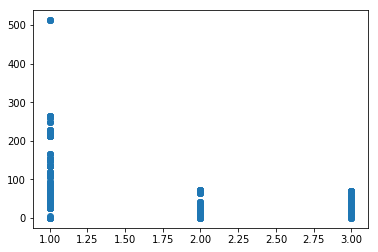

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64


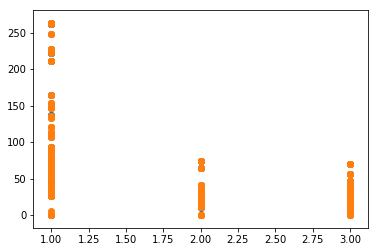

In [158]:
plt.scatter(all_df.Pclass,all_df.Fare)
plt.show()
cl_of_na=all_df.Pclass[all_df.Fare.isna()]
mean_fa_cl=all_df["Fare"].groupby(all_df.Pclass).mean()
print(mean_fa_cl)
#fill na for fare
ndf_test["Fare"]=df_test.Fare.fillna(mean_fa_cl[3])
ndf_train["Fare"]=np.where(ndf_train["Fare"]>300,mean_fa_cl[1],ndf_train["Fare"])
ndf_test["Fare"]=np.where(ndf_test["Fare"]>300,mean_fa_cl[1],ndf_test["Fare"])
plt.scatter(ndf_test.Pclass,ndf_test.Fare)
plt.scatter(ndf_train.Pclass,ndf_train.Fare)
plt.show()

In [159]:
# Check if there is a mismatch between name and sex
sam=pd.Series(["Mr","Master","Miss","Mrs"],index=[1,1,0,0])
def sex_after_name(string):
    sex=[2] # unable to identify gender based on name
    for sub in sam:
        if string.find(sub)!=-1:
            sex=sam[sam==sub].index
    return sex[0]

new_sex=all_df["Name"].apply(sex_after_name)
pd.crosstab(new_sex,all_df["Sex"])

Sex,female,male
Name,,
0,459,0
1,0,819
2,7,24


### 2.2. Transformation of variables

In [160]:
# Sex
dum_sex=pd.get_dummies(df_train.Sex)
print(dum_sex.corrwith(df_train.Survived))

ndf_train=ndf_train.join(pd.get_dummies(df_train.Sex,drop_first=True))
ndf_test=ndf_test.join(pd.get_dummies(df_test.Sex,drop_first=True))
ndf_test.head()

female    0.543351
male     -0.543351
dtype: float64


,Pclass,Fare,male
0,3,7.8292,1
1,3,7.0000,0
2,2,9.6875,1
3,3,8.6625,1
4,3,12.2875,0


In [161]:
# Embarked
dum_emb=pd.get_dummies(df_train.Embarked)
print(dum_emb.corrwith(df_train.Survived))

# Add to new data frame
ndf_train=ndf_train.join(pd.get_dummies(df_train.Embarked)[["C","S"]])
ndf_test=ndf_test.join(pd.get_dummies(df_test.Embarked)[["C","S"]])
ndf_test.head()

C    0.16824
Q    0.00365
S   -0.15566
dtype: float64


,Pclass,Fare,male,C,S
0,3,7.8292,1,0,0
1,3,7.0000,0,0,1
2,2,9.6875,1,0,0
3,3,8.6625,1,0,1
4,3,12.2875,0,0,1


In [162]:
print(pd.crosstab(df_train.Survived,df_train.SibSp))
bins=[-1,0.5,2.5,9]
new_Sib=pd.cut(df_train.SibSp,bins,labels=["0","1-2",">2"])
pd.crosstab(new_Sib,df_train["Survived"])

SibSp       0    1   2   3   4  5  8
Survived                            
0         398   97  15  12  15  5  7
1         210  112  13   4   3  0  0


Survived,0,1
SibSp,,
0,398,210
1-2,112,125
>2,39,7


In [163]:
new_Sib=pd.get_dummies(new_Sib)
new_Sib.corrwith(df_train.Survived)

0     -0.115867
1-2    0.177738
>2    -0.111145
dtype: float64

In [164]:
ndf_train=ndf_train.join(pd.get_dummies(pd.cut(df_train.SibSp,bins,labels=["0","1-2",">2"])))
ndf_test=ndf_test.join(pd.get_dummies(pd.cut(df_test.SibSp,bins,labels=["0","1-2",">2"])))
ndf_test.head()

,Pclass,Fare,male,C,S,0,1-2,>2
0,3,7.8292,1,0,0,1,0,0
1,3,7.0000,0,0,1,0,1,0
2,2,9.6875,1,0,0,1,0,0
3,3,8.6625,1,0,1,1,0,0
4,3,12.2875,0,0,1,0,1,0


In [165]:
# Parch
print(pd.crosstab(df_train.Survived,df_train.Parch))
bins=[-1,0.5,3.5,9]
new_Par=pd.cut(df_train.Parch,bins,labels=["0","1-3",">3"])
print(new_Par.value_counts())
new_Par=pd.get_dummies(new_Par)
new_Par.corrwith(df_train.Survived)

Parch       0   1   2  3  4  5  6
Survived                         
0         445  53  40  2  4  4  1
1         233  65  40  3  0  1  0
0      678
1-3    203
>3      10
Name: Parch, dtype: int64


0     -0.147408
1-3    0.165511
>3    -0.062182
dtype: float64

In [166]:
ndf_train=ndf_train.join(pd.get_dummies(pd.cut(df_train.Parch,bins,labels=["P0","P1-3","P>3"])))
ndf_test=ndf_test.join(pd.get_dummies(pd.cut(df_test.Parch,bins,labels=["P0","P1-3","P>3"])))
ndf_test.head()

,Pclass,Fare,male,C,S,0,1-2,>2,P0,P1-3,P>3
0,3,7.8292,1,0,0,1,0,0,1,0,0
1,3,7.0000,0,0,1,0,1,0,1,0,0
2,2,9.6875,1,0,0,1,0,0,1,0,0
3,3,8.6625,1,0,1,1,0,0,1,0,0
4,3,12.2875,0,0,1,0,1,0,0,1,0


In [167]:
# Fare
max=0
for i in range(12,51):
    bins=[-1,11,i,52,600]
    new_Fare=pd.cut(df_train.Fare,bins)
    #print(new_Fare.value_counts())
    #print(pd.crosstab(new_Fare,df_train["Survived"]))
    co=pd.get_dummies(new_Fare).corrwith(df_train.Survived).iloc[2]
    if np.abs(co)>max:
        max=np.abs(co)
        print(i,max)
        

12 0.06912281020827445
15 0.07423755662892721


In [168]:
bins=[-1,11,52,600]
new_Fare=pd.cut(df_train.Fare,bins)
print(new_Fare.value_counts())
print(pd.crosstab(new_Fare,df_train["Survived"]))
pd.get_dummies(new_Fare).corrwith(df_train.Survived)

(11, 52]     378
(-1, 11]     364
(52, 600]    149
Name: Fare, dtype: int64
Survived     0    1
Fare               
(-1, 11]   288   76
(11, 52]   216  162
(52, 600]   45  104


(-1, 11]    -0.299143
(11, 52]     0.078958
(52, 600]    0.289470
dtype: float64

In [169]:
ndf_train=ndf_train.join(pd.get_dummies(pd.cut(df_train.Fare,bins,labels=["Fare_low","Fare_mid","Fare_high"])))
ndf_test=ndf_test.join(pd.get_dummies(pd.cut(df_test.Fare,bins,labels=["Fare_low","Fare_mid","Fare_high"])))
ndf_test.head()

,Pclass,Fare,male,C,S,0,1-2,>2,P0,P1-3,P>3,Fare_low,Fare_mid,Fare_high
0,3,7.8292,1,0,0,1,0,0,1,0,0,1,0,0
1,3,7.0000,0,0,1,0,1,0,1,0,0,1,0,0
2,2,9.6875,1,0,0,1,0,0,1,0,0,1,0,0
3,3,8.6625,1,0,1,1,0,0,1,0,0,1,0,0
4,3,12.2875,0,0,1,0,1,0,0,1,0,0,1,0


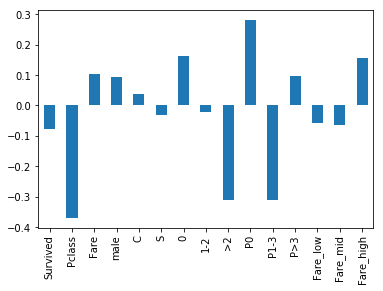

In [170]:
ndf_train.corrwith(df_train.Age).plot.bar()
plt.show()

In [171]:
bins=[-1,6,60,150]
new_Age=pd.cut(df_train.Age,bins)
print(new_Age.value_counts())
print(pd.crosstab(new_Age,df_train["Survived"]))
pd.get_dummies(new_Age).corrwith(df_train.Survived)

(6, 60]      645
(-1, 6]       47
(60, 150]     22
Name: Age, dtype: int64
Survived     0    1
Age                
(-1, 6]     14   33
(6, 60]    393  252
(60, 150]   17    5


(-1, 6]      0.154447
(6, 60]      0.022839
(60, 150]   -0.051224
dtype: float64

In [172]:
all_df.Age.isna().sum()

263

In [173]:
# Fill na for young people
def young(string):
    youn=False # unable to identify age based on name
    if (string.find("Miss")!=-1) or (string.find("Master")!=-1):
        youn=True

    return youn

kid=df_train["Name"].apply(young)
df_train.Age[kid]=df_train.Age[kid].fillna(6)
kid=df_test["Name"].apply(young)
df_test.Age[kid]=df_test.Age[kid].fillna(6)

C:\Users\Duong Hung\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Duong Hung\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [174]:
df_train.Age.isna().sum()

137

In [175]:
bins=[-1,6,60,150]
new_Age=pd.cut(df_train.Age,bins)
print(new_Age.value_counts())
print(pd.crosstab(new_Age,df_train["Survived"]))
pd.get_dummies(new_Age).corrwith(df_train.Survived)

(6, 60]      645
(-1, 6]       87
(60, 150]     22
Name: Age, dtype: int64
Survived     0    1
Age                
(-1, 6]     30   57
(6, 60]    393  252
(60, 150]   17    5


(-1, 6]      0.183533
(6, 60]      0.022839
(60, 150]   -0.051224
dtype: float64

In [176]:
ndf_train=ndf_train.join(pd.get_dummies(pd.cut(df_train.Age,bins,labels=["A1","A2","A3"])))
ndf_test=ndf_test.join(pd.get_dummies(pd.cut(df_test.Parch,bins,labels=["A1","A2","A3"])))
ndf_test.head()

,Pclass,Fare,male,C,S,0,1-2,>2,P0,P1-3,P>3,Fare_low,Fare_mid,Fare_high,A1,A2,A3
0,3,7.8292,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
1,3,7.0000,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0
2,2,9.6875,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,3,8.6625,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0
4,3,12.2875,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0


In [177]:
ndf_train.drop(columns=["P>3","Fare_mid","A2","A3"],inplace=True)
ndf_train.head()

,Survived,Pclass,Fare,Embarked,male,C,S,0,1-2,>2,P0,P1-3,Fare_low,Fare_high,A1
0,0,3,7.2500,S,1,0,1,0,1,0,1,0,1,0,0
1,1,1,71.2833,C,0,1,0,0,1,0,1,0,0,1,0
2,1,3,7.9250,S,0,0,1,1,0,0,1,0,1,0,0
3,1,1,53.1000,S,0,0,1,0,1,0,1,0,0,1,0
4,0,3,8.0500,S,1,0,1,1,0,0,1,0,1,0,0


In [178]:
ndf_train.drop(columns=["Survived","Embarked"],inplace=True)

In [179]:
ndf_test.drop(columns=["P>3","Fare_mid","A2","A3"],inplace=True)
ndf_test.head()

,Pclass,Fare,male,C,S,0,1-2,>2,P0,P1-3,Fare_low,Fare_high,A1
0,3,7.8292,1,0,0,1,0,0,1,0,1,0,1
1,3,7.0000,0,0,1,0,1,0,1,0,1,0,1
2,2,9.6875,1,0,0,1,0,0,1,0,1,0,1
3,3,8.6625,1,0,1,1,0,0,1,0,1,0,1
4,3,12.2875,0,0,1,0,1,0,0,1,0,0,1


0.8212290502793296


C:\Users\Duong Hung\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


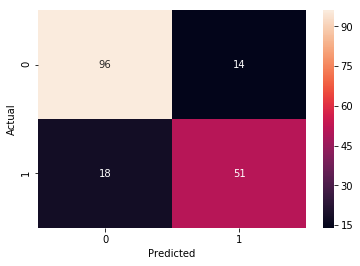

0.8089887640449438


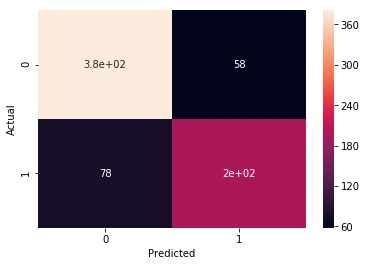

In [180]:

X_train,X_test,y_train,y_test = train_test_split(ndf_train,df_train.Survived,test_size=0.20,random_state=0)
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print((confusion_matrix.iloc[0,0]+confusion_matrix.iloc[1,1])/len(y_pred))
sns.heatmap(confusion_matrix, annot=True)
plt.show()
y_pred_train=logistic_regression.predict(X_train)
confusion_matrix_train = pd.crosstab(y_train, y_pred_train, rownames=['Actual'], colnames=['Predicted'])
print((confusion_matrix_train.iloc[0,0]+confusion_matrix_train.iloc[1,1])/len(y_pred_train))
sns.heatmap(confusion_matrix_train, annot=True)
plt.show()

0.8069584736251403


C:\Users\Duong Hung\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


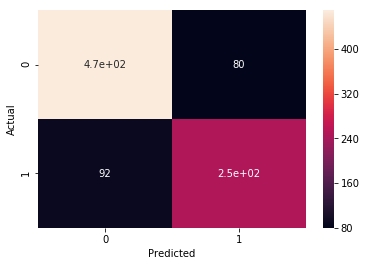

In [181]:
logistic_regression= LogisticRegression()
logistic_regression.fit(ndf_train,df_train.Survived)
y_pred_train=logistic_regression.predict(ndf_train)
confusion_matrix_train = pd.crosstab(df_train.Survived, y_pred_train, rownames=['Actual'], colnames=['Predicted'])
print((confusion_matrix_train.iloc[0,0]+confusion_matrix_train.iloc[1,1])/len(y_pred_train))
sns.heatmap(confusion_matrix_train, annot=True)
plt.show()


In [182]:
ndf_test.shape

(418, 13)

In [184]:
y_pred=logistic_regression.predict(ndf_test)
submission=pd.DataFrame()
submission["PassengerId"]=df_test.PassengerId
submission["Survived"]=y_pred
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [186]:
submission.to_csv("LR_submission_2.csv",index=False)

In [187]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(ndf_train, df_train.Survived)
y_pred = svc.predict(ndf_test)

C:\Users\Duong Hung\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [188]:
y_pred=svc.predict(ndf_test)
submission=pd.DataFrame()
submission["PassengerId"]=df_test.PassengerId
submission["Survived"]=y_pred
submission.head()
submission.to_csv("SVC_submission_0.csv",index=False)

0.776536312849162


C:\Users\Duong Hung\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


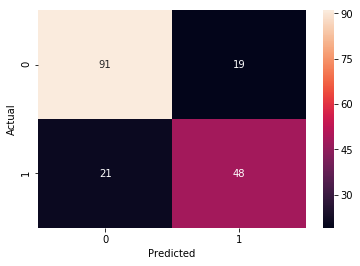

0.8160112359550562


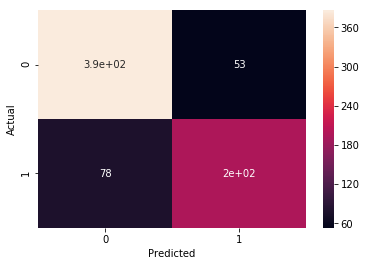

In [189]:
X_train,X_test,y_train,y_test = train_test_split(ndf_train,df_train.Survived,test_size=0.20,random_state=0)
svc = SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print((confusion_matrix.iloc[0,0]+confusion_matrix.iloc[1,1])/len(y_pred))
sns.heatmap(confusion_matrix, annot=True)
plt.show()
y_pred_train=svc.predict(X_train)
confusion_matrix_train = pd.crosstab(y_train, y_pred_train, rownames=['Actual'], colnames=['Predicted'])
print((confusion_matrix_train.iloc[0,0]+confusion_matrix_train.iloc[1,1])/len(y_pred_train))
sns.heatmap(confusion_matrix_train, annot=True)
plt.show()
